# Описание датасета Customer Shopping Dataset - Retail Sales Data

**Изучение анализа потребительской корзины в данных о розничной торговле в Стамбуле**

[Датасет](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset) содержит информацию о покупках в 10 различных торговых центрах Стамбула за период с 2021 по 2023 год. Данные по различным возрастным группам и полам дают полное представление о покупательских привычках населения.

В датасете содержатся следующие атрибуты:

| Название признака   | Описание                                                        |
|:-------------------:|-----------------------------------------------------------------|
| invoice_no          | Номер счета-фактуры. Уникальный идентификатор операции          |
| customer_id         | Идентификатор клиента. Уникальный номер клиента                |
| gender              | Пол клиента (мужской/женский)                                  |
| age                 | Возраст клиента (целое положительное число)                    |
| category            | Категория приобретённого товара                                |
| quantity            | Количество товара в транзакции                                 |
| price               | Цена за единицу товара (в турецких лирах, TL)                  |
| payment_method      | Способ оплаты (наличные, кредитная карта, дебетовая карта)     |
| invoice_date        | Дата совершения покупки                                         |
| shopping_mall       | Название торгового центра, где была совершена покупка          |

# Импорт библиотек

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import entropy
from itertools import combinations

# Чтение датасета

Удалим признаки `invoice_no` идентификатора операции и `customer_id` номера клиента, так как у нас все клиенты и операции в датасете уникальны. Преобразуем дату совершения покупки `invoice_date` в формат datetime.

In [2]:
path = kagglehub.dataset_download("mehmettahiraslan/customer-shopping-dataset")
data = pd.read_csv(path + '/customer_shopping_data.csv')
data = data.drop(columns=['invoice_no']).drop(columns=['customer_id']).astype({'invoice_date': 'datetime64[ns]'})

data.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,Female,28,Clothing,5,1500.40,Credit Card,2022-05-08,Kanyon
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul
2,Male,20,Clothing,1,300.08,Cash,2021-09-11,Metrocity
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon


# Продуктовая гипотеза и целевая метрика

**Гипотеза:** Внедрение новой модели ценообразования приведёт к увеличению среднего чека покупателей в торговых центрах Стамбула.

**Целевая метрика:** Средний чек (Average Order Value, AOV) — средняя сумма покупки на одного клиента за одну транзакцию в день.

**Эксперимент:**
- Провести A/B тестирование: сравнить средний чек между группой, где применяется старая модель ценообразования (контрольная группа), и группой с новой моделью (тестовая группа).
- Если средний чек в тестовой группе статистически значимо выше, гипотеза подтверждается и новая модель может быть рекомендована к внедрению.

# Анализ данных

Так как мы будем разворачивать нашу новую систему ценообразования на магазины, нам необходимо убедиться в наличии данных по этим магазинам на каждый день.

Период дат: 01-01-2021 — 02-12-2023


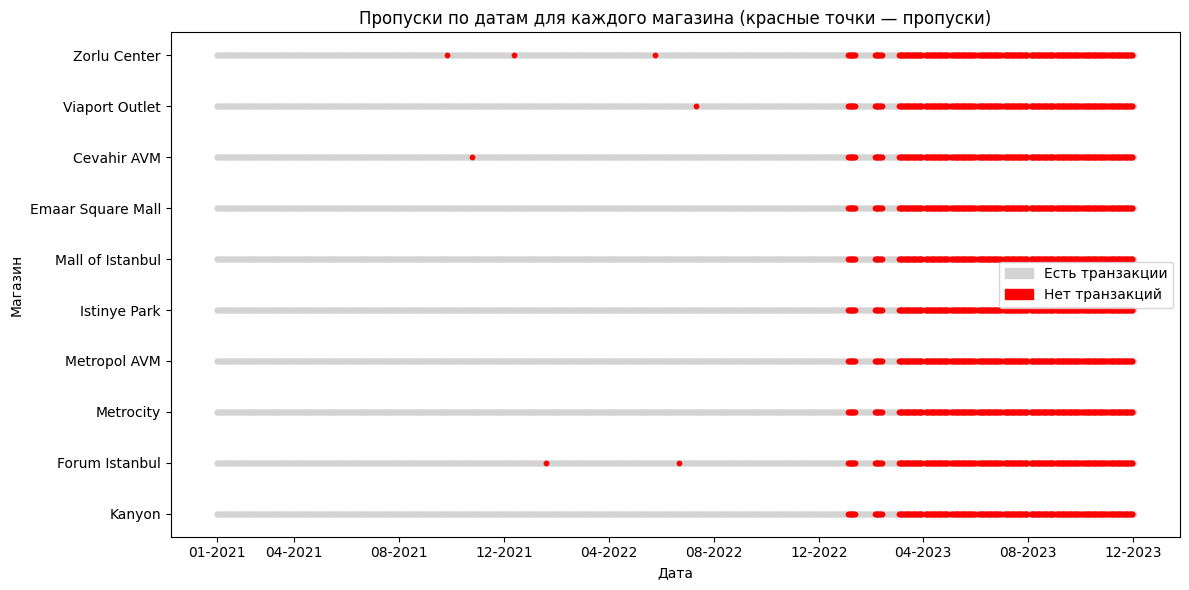

In [3]:
all_malls_full = data["shopping_mall"].unique()
all_days_full = pd.date_range(data["invoice_date"].min(), data["invoice_date"].max())

print(
    f'Период дат: {data["invoice_date"].min().strftime("%d-%m-%Y")} — {data["invoice_date"].max().strftime("%d-%m-%Y")}'
)

plt.figure(figsize=(12, 6))

for i, mall in enumerate(all_malls_full):
    mall_dates = set(data[data["shopping_mall"] == mall]["invoice_date"])
    missing_dates = [d for d in all_days_full if d not in mall_dates]
    plt.scatter([d for d in all_days_full], [i] * len(all_days_full), color="lightgray", s=10)
    plt.scatter(missing_dates, [i] * len(missing_dates), color="red", s=10)

tick_dates = pd.date_range(
    start=data["invoice_date"].min().replace(day=1),
    end=data["invoice_date"].max().replace(day=1),
    periods=10,
)
tick_dates = [d.replace(day=1, hour=0, minute=0, second=0, microsecond=0) for d in tick_dates]

xticks = mdates.date2num(tick_dates)
xticklabels = [d.strftime("%m-%Y") for d in tick_dates]
plt.xticks(xticks, xticklabels)
plt.yticks(range(len(all_malls_full)), all_malls_full)

plt.xlabel("Дата")
plt.ylabel("Магазин")
plt.title("Пропуски по датам для каждого магазина (красные точки — пропуски)")

red_patch = mpatches.Patch(color="red", label="Нет транзакций")
gray_patch = mpatches.Patch(color="lightgray", label="Есть транзакции")
plt.legend(handles=[gray_patch, red_patch])

plt.tight_layout()
plt.show()

**Результаты визуализации:**
В 2023 году наблюдается большое количество пропусков данных по всем магазинам, особенно начиная с весны. Это делает невозможным корректный анализ и сравнение магазинов за этот период.

Отбросим данные за 2023 год из дальнейшего анализа, чтобы не искажать результаты A/B теста.

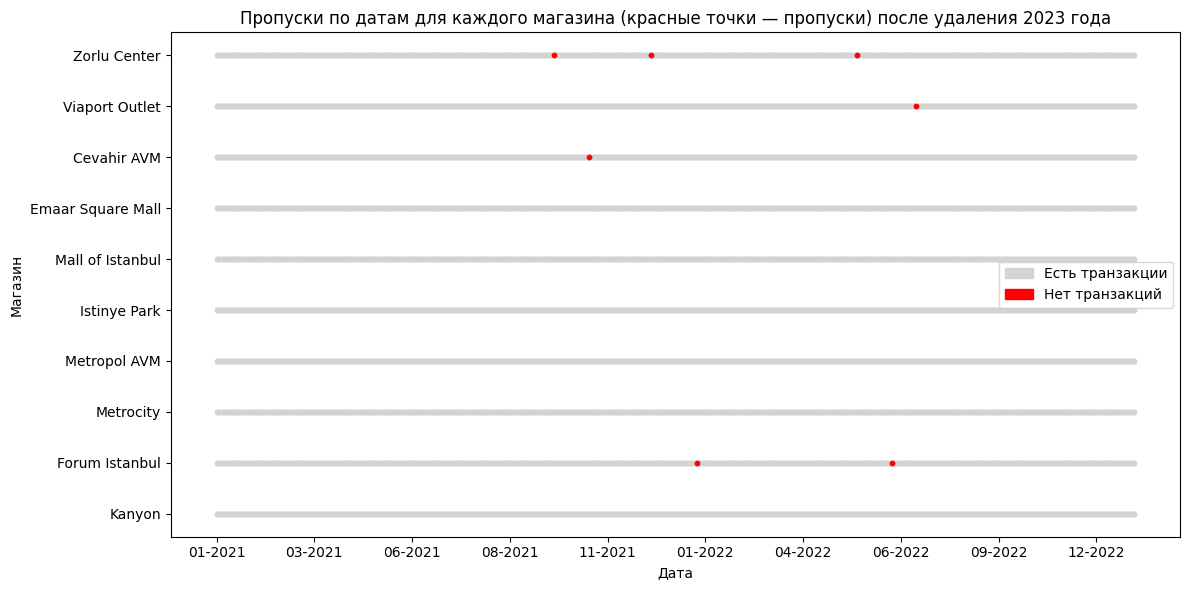

In [4]:
data = data[data["invoice_date"].dt.year < 2023]

all_malls_full = data["shopping_mall"].unique()
all_days_full = pd.date_range(data["invoice_date"].min(), data["invoice_date"].max())

plt.figure(figsize=(12, 6))

for i, mall in enumerate(all_malls_full):
    mall_dates = set(data[data["shopping_mall"] == mall]["invoice_date"])
    missing_dates = [d for d in all_days_full if d not in mall_dates]
    plt.scatter(
        [d for d in all_days_full], [i] * len(all_days_full), color="lightgray", s=10
    )
    plt.scatter(missing_dates, [i] * len(missing_dates), color="red", s=10)

xticks = mdates.date2num(
    pd.date_range(
        start=data["invoice_date"].min().replace(day=1),
        end=data["invoice_date"].max().replace(day=1),
        periods=10,
    )
)
xticklabels = [
    pd.Timestamp(d).strftime("%m-%Y")
    for d in pd.date_range(
        start=data["invoice_date"].min().replace(day=1),
        end=data["invoice_date"].max().replace(day=1),
        periods=10,
    )
]
plt.xticks(xticks, xticklabels)
plt.yticks(range(len(all_malls_full)), all_malls_full)

plt.xlabel("Дата")
plt.ylabel("Магазин")
plt.title(
    "Пропуски по датам для каждого магазина (красные точки — пропуски) после удаления 2023 года"
)

red_patch = mpatches.Patch(color="red", label="Нет транзакций")
gray_patch = mpatches.Patch(color="lightgray", label="Есть транзакции")
plt.legend(handles=[gray_patch, red_patch])

plt.tight_layout()
plt.show()

**Вывод для дальнейшего анализа:**
Для проведения A/B теста мы не будем учитывать те дни, для которых отсутствуют данные хотя бы в одном из тестируемых магазинов. Это позволит избежать искажения результатов и обеспечит корректность сравнения между группами.

**Отделим шесть последних месяцев из датасета** — это будут данные из будущего, которые нам неизвестны. <br> Оставшаяся часть будет считаться историческими данными, на которых проведём анализ.

In [5]:
last_date = data['invoice_date'].max()
future_start = last_date - pd.DateOffset(months=6)
historical_data = data[data['invoice_date'] < future_start]
future_data = data[data['invoice_date'] >= future_start]

**Рассчитаем средний чек за каждый день по всем магазинам в сумме.** Сначала вычисляется сумма покупок (количество × цена) по всем магазинам для каждой даты, затем строится гистограмма распределения среднего чека по дням. Также вычисляется дисперсия среднего чека, чтобы оценить разброс значений между днями.

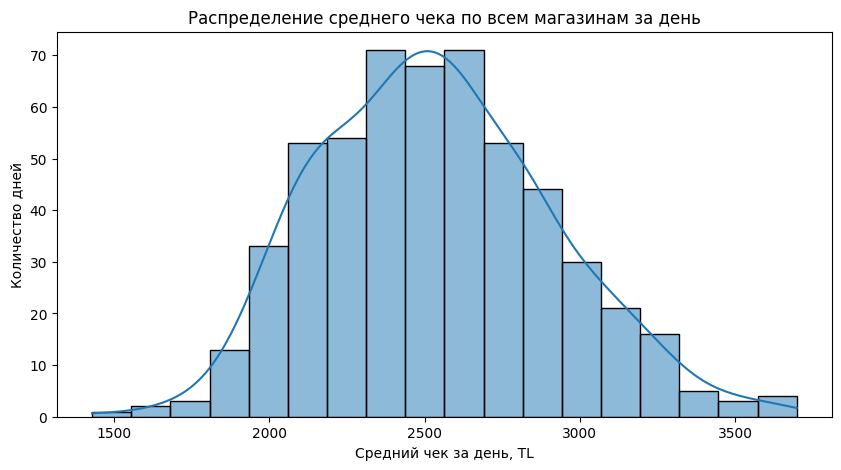

Дисперсия среднего чека по всем магазинам за день: 140041.66


In [6]:
daily_stats = historical_data.groupby('invoice_date').agg(
    total_sum = ('quantity', lambda x: (x * historical_data.loc[x.index, 'price']).sum()),
    n_transactions = ('quantity', 'size')
).reset_index()
daily_stats['avg_order_value'] = daily_stats['total_sum'] / daily_stats['n_transactions']

plt.figure(figsize=(10, 5))
sns.histplot(daily_stats['avg_order_value'], kde=True)
plt.title('Распределение среднего чека по всем магазинам за день')
plt.xlabel('Средний чек за день, TL')
plt.ylabel('Количество дней')
plt.show()

variance_aov = np.var(daily_stats['avg_order_value'])
print(f'Дисперсия среднего чека по всем магазинам за день: {variance_aov:.2f}')

## Анализ структуры клиентской базы и продаж по магазинам
Сравним относительные распределения по гендеру, категориям товаров, методам оплаты и возрасту клиентов для каждого магазина. Это позволит выявить различия в аудитории и предпочтениях покупателей между торговыми центрами.

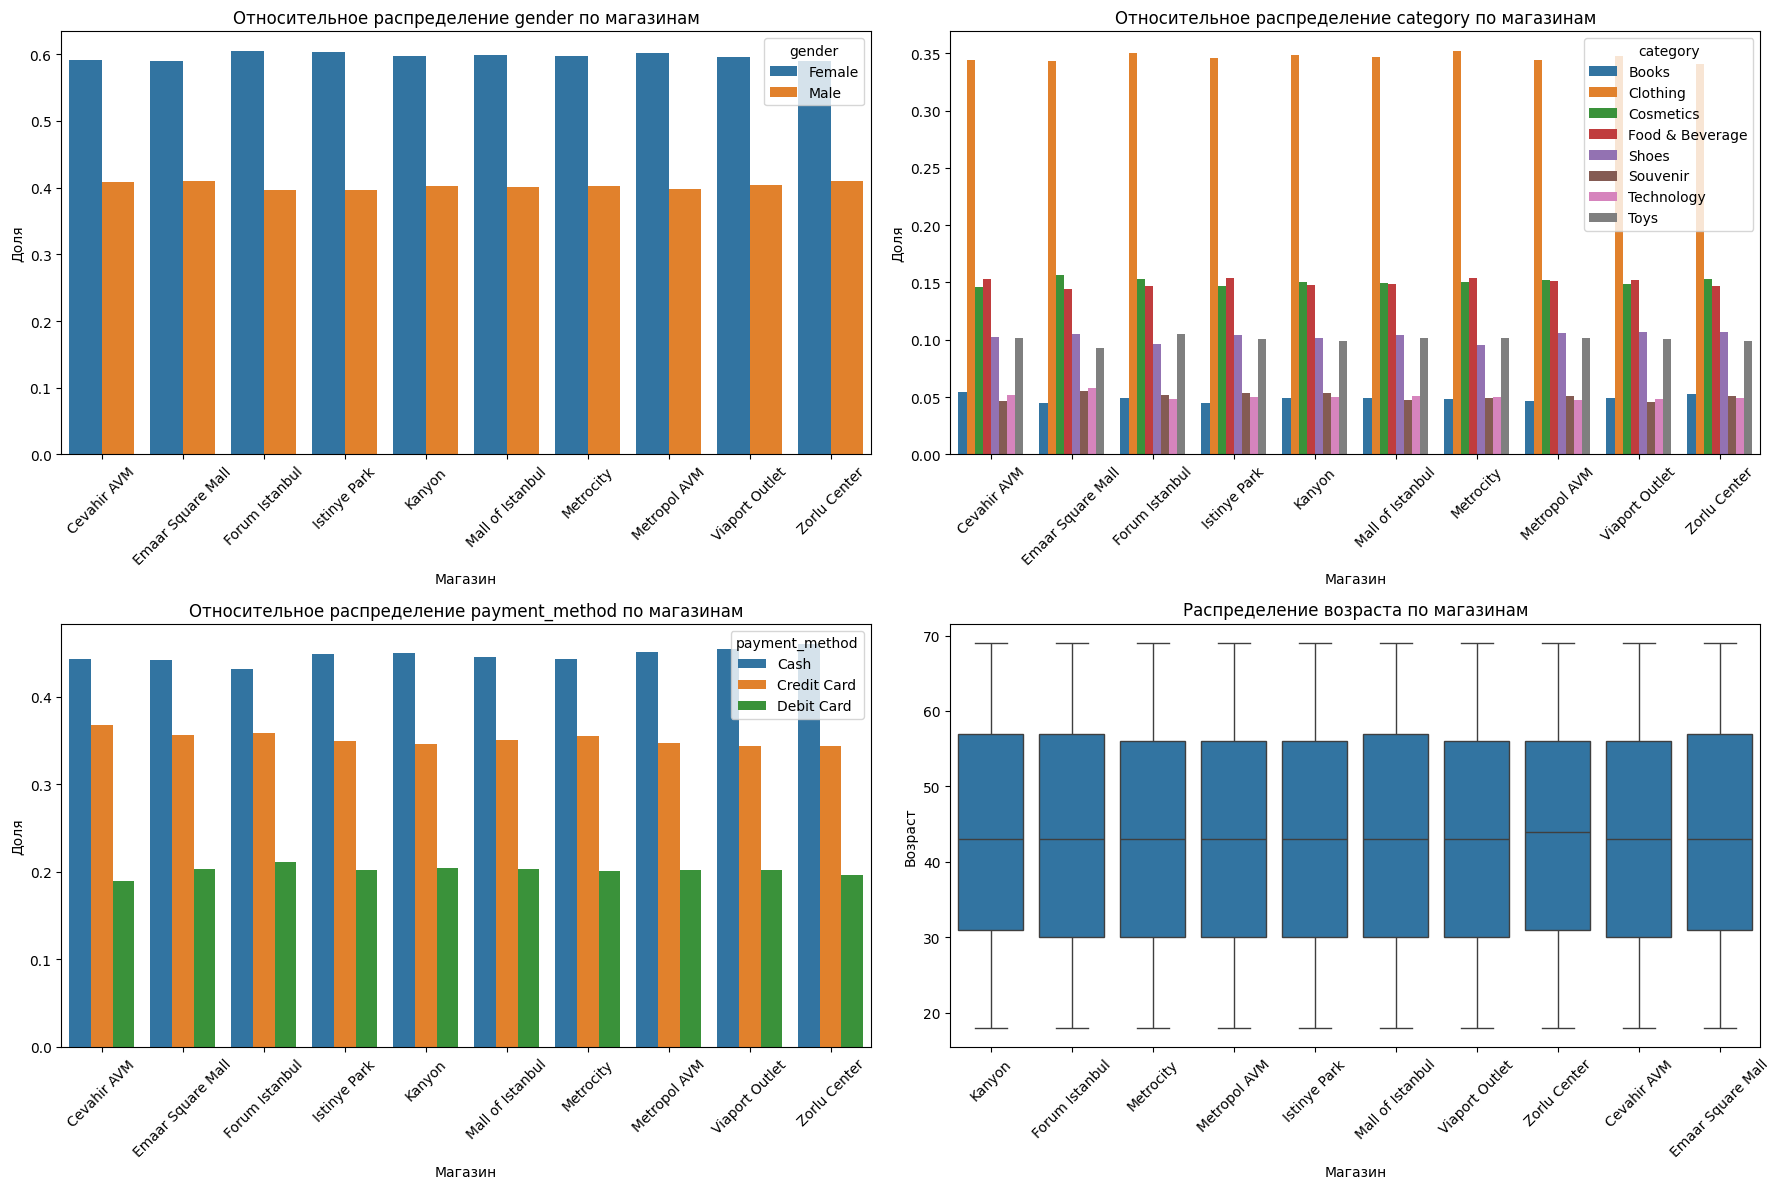

In [7]:
features = ['gender', 'category', 'payment_method']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]
    counts = historical_data.groupby(['shopping_mall', feature]).size().reset_index(name='count')
    total = historical_data.groupby('shopping_mall').size().reset_index(name='total')
    counts = counts.merge(total, on='shopping_mall')
    counts['ratio'] = counts['count'] / counts['total']
    sns.barplot(data=counts, x='shopping_mall', y='ratio', hue=feature, ax=ax)
    ax.set_title(f'Относительное распределение {feature} по магазинам')
    ax.set_xlabel('Магазин')
    ax.set_ylabel('Доля')
    ax.legend(title=feature)
    ax.tick_params(axis='x', rotation=45)

ax = axes[3]
sns.boxplot(data=historical_data, x='shopping_mall', y='age', ax=ax)
ax.set_title('Распределение возраста по магазинам')
ax.set_xlabel('Магазин')
ax.set_ylabel('Возраст')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Видим, что все торговые центры имеют одинаковые относительные распределения. Следовательно разбивать магазины на группы, учитывая эти показатели, не имеет необходимости.

### Количество транзакций по магазинам
Сравним общее количество транзакций в каждом магазине. Это позволит оценить активность торговых точек и выявить лидеров по объёму продаж.

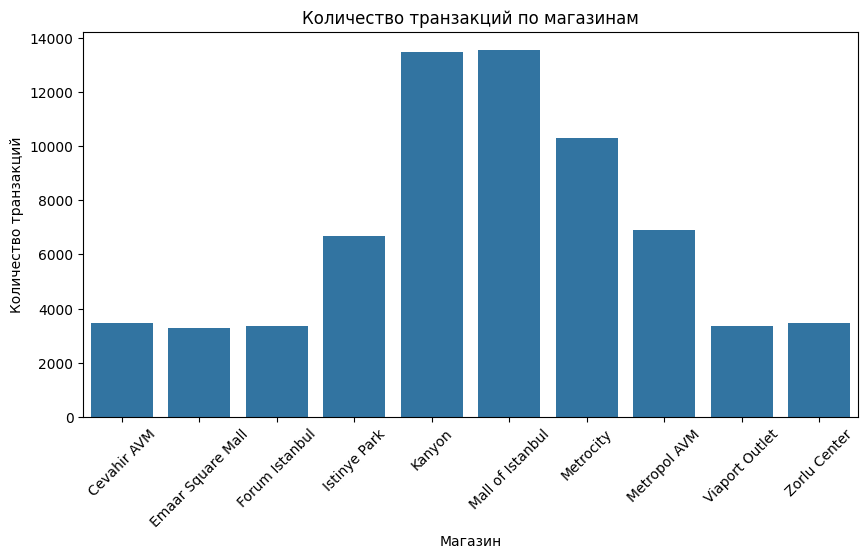

In [8]:
plt.figure(figsize=(10, 5))
trans_counts = historical_data['shopping_mall'].value_counts().sort_index()
ax = sns.barplot(x=trans_counts.index, y=trans_counts.values)
plt.title('Количество транзакций по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Количество транзакций')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Распределение среднего чека за день по магазинам
Сравним распределение среднего чека за день по каждому магазину. Это позволит выявить различия в покупательской активности и ценовой политике между торговыми центрами.

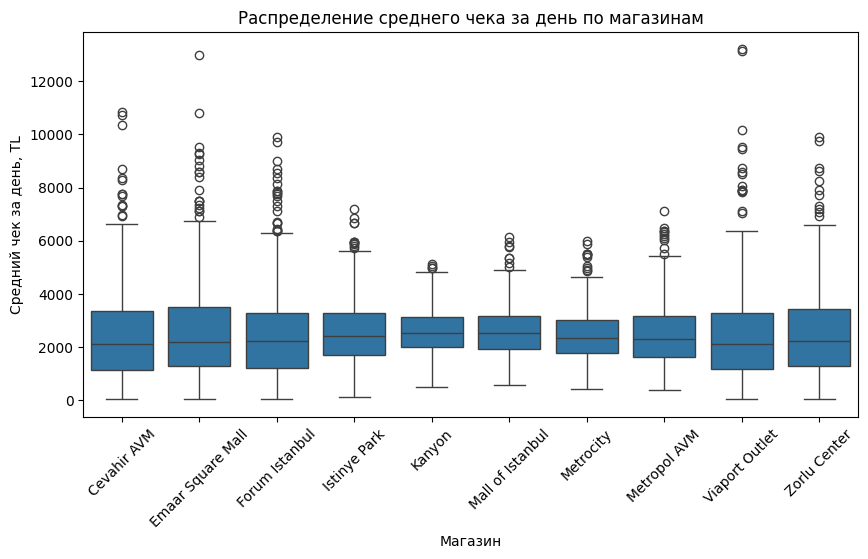

In [9]:
store_daily_aov = historical_data.groupby(['shopping_mall', 'invoice_date']).agg(
    total_sum = ('quantity', lambda x: (x * historical_data.loc[x.index, 'price']).sum()),
    n_transactions = ('quantity', 'size')
).reset_index()
store_daily_aov['avg_order_value'] = store_daily_aov['total_sum'] / store_daily_aov['n_transactions']

plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=store_daily_aov, x='shopping_mall', y='avg_order_value')
plt.title('Распределение среднего чека за день по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Средний чек за день, TL')
ax.tick_params(axis='x', rotation=45)
plt.show()

### Вывод по структуре клиентской базы и продаж
На основе графиков видно, что количество транзакций и распределение среднего чека варьируются между магазинами. Это важно учитывать при формировании контрольной и тестовой групп для A/B теста.

# Дизайн эксперимента

Анализ показал, что ключевые различия между магазинами проявляются именно в распределениях среднего чека за день. Поэтому для корректного проведения A/B‑теста важно, чтобы контрольная и тестовая группы были максимально похожи именно по этим распределениям, а не только по средним значениям.

Для этого мы будем формировать группы магазинов так, чтобы их распределения среднего чека были как можно более близки друг к другу. В качестве формальной меры близости используем **дивергенцию Йенсена — Шеннона (JS‑дивергенцию)**, которая симметрично и интерпретируемо измеряет различие между двумя вероятностными распределениями.

Минимизируя JS‑дивергенцию между группами, мы обеспечиваем максимальную сопоставимость их покупательского поведения и тем самым корректность результатов эксперимента.

## Оптимальное разбиение магазинов на группы по Jensen–Shannon дивергенции
 
**Jensen–Shannon дивергенция (JS‑дивергенция)** — симметричная мера различия между двумя распределениями. Для корректного A/B‑теста важно, чтобы распределения дневных средних чеков в тестовой и контрольной группах были максимально похожи.

**Алгоритм оптимального разбиения:**
1. Для каждого разбиения магазинов на группы (например, 5+5 или 4+4) объединяем все дневные средние чеки по магазинам в каждой группе.
2. Строим гистограммы (или ядерные оценки плотности) для обеих групп на одинаковых бинах.
3. Преобразуем гистограммы в вероятностные векторы $P$ и $Q$ (сумма = 1).
4. Вычисляем JS‑дивергенцию между этими распределениями:
   $$\mathrm{JS}(P\|Q) = \tfrac12\,[\mathrm{KL}(P\|M) + \mathrm{KL}(Q\|M)],\quad M=\tfrac12(P+Q)$$
5. Перебираем все возможные разбиения и выбираем то, где JS‑дивергенция минимальна.

**Чем меньше JS‑дивергенция, тем более сбалансированы группы по распределению дневных средних чеков.**
 
Этот подход позволяет объективно и формально подобрать наилучшее разбиение магазинов для A/B‑теста.

In [10]:
def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m, base=2)
    kl_qm = entropy(q, m, base=2)
    return 0.5 * (kl_pm + kl_qm)

malls = store_daily_aov['shopping_mall'].unique()
D = store_daily_aov['invoice_date'].nunique()

mall2aov = {mall: store_daily_aov[store_daily_aov['shopping_mall'] == mall]['avg_order_value'].values for mall in malls}

def get_group_distribution(mall_group, bins):
    values = np.concatenate([mall2aov[m] for m in mall_group])
    hist, _ = np.histogram(values, bins=bins, density=True)
    hist = hist / hist.sum() # нормируем
    return hist

def find_best_js_partition(malls, group_size, verbose=True):
    best_js = float('inf')
    best_split = None
    all_values = np.concatenate([mall2aov[m] for m in malls])
    bins = np.histogram_bin_edges(all_values, bins='auto')
    checked = set()
    malls = list(malls)
    total = 0
    for groupA in combinations(malls, group_size):
        rest = set(malls) - set(groupA)
        for groupB in combinations(rest, group_size):
            key = tuple(sorted(groupA)) + tuple(sorted(groupB))
            if key in checked:
                continue
            checked.add(key)
            checked.add(tuple(sorted(groupB)) + tuple(sorted(groupA)))
            p = get_group_distribution(groupA, bins)
            q = get_group_distribution(groupB, bins)
            js = jensen_shannon_divergence(p, q)
            total += 1
            if js < best_js:
                best_js = js
                best_split = (groupA, groupB)
    if verbose:
        print(f'Всего проверено пар: {total}')
    return best_js, best_split

def print_groups(split, title1="Группа 1", title2="Группа 2"):
    groupA, groupB = split
    print(f"{title1:<20} | {title2:<20}")
    print("-"*21 + "+" + "-"*21)
    max_len = max(len(groupA), len(groupB))
    for i in range(max_len):
        a = groupA[i] if i < len(groupA) else ""
        b = groupB[i] if i < len(groupB) else ""
        print(f"{a:<20} | {b:<20}")


print('Перебор всех разбиений 5+5...')
js_5, split_5 = find_best_js_partition(malls, 5)
print(f'Лучшая JS-дивергенция для 5+5: {js_5:.4f}')
print_groups(split_5, title1="Группа 1 (5)", title2="Группа 2 (5)")

print('\nПеребор всех разбиений 4+4...')
js_4, split_4 = find_best_js_partition(malls, 4)
print(f'Лучшая JS-дивергенция для 4+4: {js_4:.4f}')
print_groups(split_4, title1="Группа 1 (4)", title2="Группа 2 (4)")

Перебор всех разбиений 5+5...
Всего проверено пар: 126
Лучшая JS-дивергенция для 5+5: 0.0067
Группа 1 (5)         | Группа 2 (5)        
---------------------+---------------------
Cevahir AVM          | Mall of Istanbul    
Forum Istanbul       | Zorlu Center        
Istinye Park         | Viaport Outlet      
Kanyon               | Metrocity           
Metropol AVM         | Emaar Square Mall   

Перебор всех разбиений 4+4...
Всего проверено пар: 1575
Лучшая JS-дивергенция для 4+4: 0.0057
Группа 1 (4)         | Группа 2 (4)        
---------------------+---------------------
Cevahir AVM          | Forum Istanbul      
Emaar Square Mall    | Zorlu Center        
Mall of Istanbul     | Metropol AVM        
Metrocity            | Kanyon              


> **Примечание:** Несмотря на то, что оптимальное разбиение магазинов на две группы по 4 (4+4) даёт чуть более низкое значение JS-дивергенции по сравнению с разбиением 5+5, мы выбираем вариант с двумя группами по 5 магазинов. Это связано с тем, что разница в дивергенции между этими вариантами минимальна, а увеличение числа магазинов в каждой группе позволяет повысить статистическую мощность теста и сделать выводы более надёжными.

### Визуализация разбиения на группы

На графике ниже показано распределение среднего чека за день по каждому магазину. Цвет боксплота соответствует группе, в которую магазин попал после оптимального разбиения по дивергенции Йенсена — Шеннона: бирюзовый — первая группа, синий — вторая. Такой подход позволяет убедиться, что группы действительно сопоставимы по распределениям среднего чека.

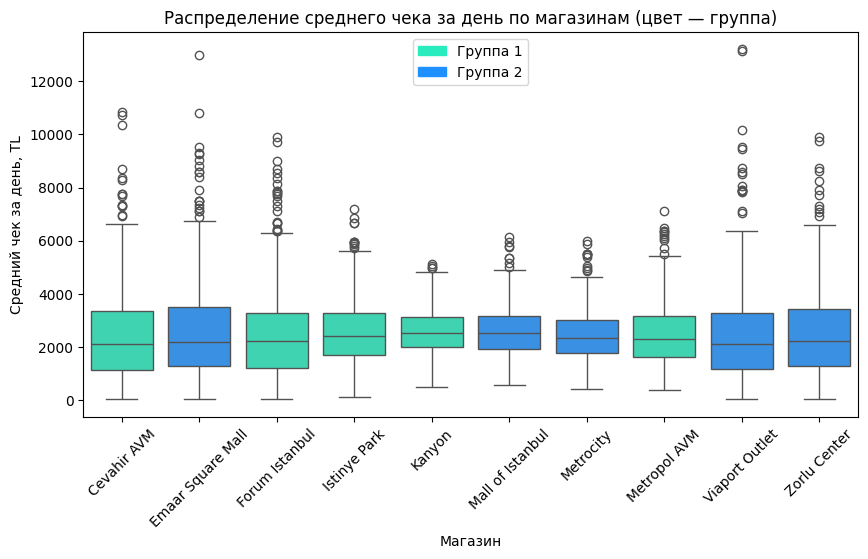

In [11]:
plt.figure(figsize=(10, 5))

groupA, groupB = split_5
palette = {mall: "#28EBBE" for mall in groupA}
palette.update({mall: "#1E90FF" for mall in groupB})

ax = sns.boxplot(data=store_daily_aov, x='shopping_mall', y='avg_order_value',
                 hue='shopping_mall', palette=palette, legend=False)
plt.title('Распределение среднего чека за день по магазинам (цвет — группа)')
plt.xlabel('Магазин')
plt.ylabel('Средний чек за день, TL')
ax.tick_params(axis='x', rotation=45)

patchA = mpatches.Patch(color="#28EBBE", label="Группа 1")
patchB = mpatches.Patch(color="#1E90FF", label="Группа 2")
plt.legend(handles=[patchA, patchB])
plt.show()

## Аналитический подход

Для корректного определения длительности эксперимента и количества наблюдений важно учесть два источника случайности:
 
1. **Межмагазинная дисперсия** $\sigma^2$ — отражает разброс средних чеков между магазинами.
2. **Внутримагазинная дисперсия транзакций** $\sigma_t^2$ — характеризует, насколько сильно варьируются суммы отдельных чеков внутри одного магазина.

### Оценка дисперсии $\sigma^2$ по метрике среднего чека магазинов
В качестве независимых наблюдений берутся магазины, а метрика $C_i$ для каждого магазина $i$ рассчитывается как средний чек за день, усреднённый по всем дням исторического периода:
$$
C_i = \frac{1}{D}\sum_{d=1}^{D} (\text{средний чек магазина }i\text{ в дне }d),
$$
где $D$ — число дней в выбранном периоде.

Далее по 10 магазинам вычисляется выборочная дисперсия этих метрик:
$$
\hat\sigma^2 = \frac{1}{10-1}\sum_{i=1}^{10} (C_i - \bar C)^2, \quad \bar C = \frac1{10}\sum_{i=1}^{10}C_i.
$$
Получаем оценку дисперсии $\sigma^2$ для дальнейших статистических расчётов.

In [12]:
D = historical_data['invoice_date'].nunique()

store_daily_aov = historical_data.groupby(['shopping_mall', 'invoice_date']).agg(
    total_sum = ('quantity', lambda x: (x * historical_data.loc[x.index, 'price']).sum()),
    n_transactions = ('quantity', 'size')
).reset_index()
store_daily_aov['avg_order_value'] = store_daily_aov['total_sum'] / store_daily_aov['n_transactions']

C_i = store_daily_aov.groupby('shopping_mall')['avg_order_value'].sum() / D

print('Метрика C_i для каждого магазина:')
print(C_i)

variance_Ci = np.var(C_i, ddof=1)
print(f'\nВыборочная дисперсия метрики C_i по магазинам: {variance_Ci:.2f}')

Метрика C_i для каждого магазина:
shopping_mall
Cevahir AVM          2494.549144
Emaar Square Mall    2610.691962
Forum Istanbul       2489.611263
Istinye Park         2557.935979
Kanyon               2559.887865
Mall of Istanbul     2582.186408
Metrocity            2454.029914
Metropol AVM         2485.210694
Viaport Outlet       2456.388488
Zorlu Center         2504.140564
Name: avg_order_value, dtype: float64

Выборочная дисперсия метрики C_i по магазинам: 2950.11


### Оценка внутримагазинной дисперсии транзакций и длительности эксперимента
 
Для корректного сравнения средних чеков между магазинами важно не только учитывать разброс между магазинами, но и понимать, насколько точно мы измеряем средний чек внутри каждого магазина.
 
Пусть в магазине в день совершается $T$ транзакций, а дисперсия суммы чека внутри магазина — $\sigma_t^2$. Тогда стандартная ошибка среднего чека за один день равна:
 
$$
  SE = \frac{\sigma_t}{\sqrt{T}}
$$
 
Чтобы внутримагазинный шум не мешал обнаружить межмагазинный эффект $\Delta$, требуется:
 
$$
  SE \le \frac{\Delta}{2} \quad \Longrightarrow \quad T \ge \left(\frac{2\sigma_t}{\Delta}\right)^2
$$
 
То есть, чем больше транзакций в каждом магазине за период теста, тем точнее будет оценка среднего чека $C_i$. При коротком периоде $C_i$ будет более шумным, при длинном — ближе к истинному среднему.
 
---
 
**Как рассчитать внутримагазинную дисперсию и минимальную длительность теста:**
 
1. Оценим дисперсию чеков по всем магазинам:
   
   $$
     \hat\sigma_t^2 = \frac{1}{N-1}\sum_{j=1}^{N} (A_j - \bar A)^2, \quad \bar A = \frac1N\sum_{j=1}^N A_j
   $$
   где $A_j$ — сумма $j$‑й транзакции, $N$ — общее число транзакций.
2. Найдём среднее число транзакций в день на магазин:
   
   $$
     T = \frac{\text{общее число транзакций}}{\text{число магазинов} \times \text{число дней}}
   $$
3. Минимальная длительность теста $D$ для заданной точности:
   
   $$
     SE(\widehat C_i) = \frac{\sigma_t}{\sqrt{T D}} \le \frac{\Delta}{2} \quad \Longrightarrow \quad
      \sqrt{T\,D} \; \ge \; \frac{2\,\sigma_t}{\Delta} \quad \Longrightarrow \quad 
      D \ge \frac{4\sigma_t^2}{\Delta^2 T}
   $$
 
Таким образом, чтобы получить надёжную оценку среднего чека и обнаружить заданный эффект, нужно провести тест достаточной длительности, чтобы в каждом магазине накопилось достаточно транзакций.

#### Удаление выбросов по сумме чека и расчёт статистик

Для корректного анализа удалим выбросы с очень большими чеками. Обычно выбросы определяют как значения, превышающие 99-й перцентиль распределения суммы чека. После удаления рассчитаем внутримагазинную дисперсию, среднее число транзакций, эффект и минимальную длительность теста.

Такой подход позволяет формально обосновать, сколько дней необходимо проводить A/B‑тест, чтобы внутримагазинная дисперсия не мешала выявить заданный эффект на уровне среднего чека каждого магазина.

In [13]:
transaction_amounts = historical_data['quantity'] * historical_data['price']

threshold = transaction_amounts.quantile(0.99)
transaction_amounts = transaction_amounts[transaction_amounts <= threshold]

N = len(transaction_amounts)
mean_A = transaction_amounts.mean()
sigma_t2 = ((transaction_amounts - mean_A) ** 2).sum() / (N - 1)
print(f'Оценка внутримагазинной дисперсии sigma_t^2: {sigma_t2:.2f}')

num_days = historical_data['invoice_date'].nunique()
num_stores = historical_data['shopping_mall'].nunique()
T = N / (num_stores * num_days)
print(f'Среднее число транзакций в день на магазин T: {T:.2f}')

Delta = 0.07 * mean_A
print(f'Эффект Delta (7% от среднего чека): {Delta:.2f}')

D_min = 4 * sigma_t2 / (Delta ** 2 * T)
print(f'\nМинимальная длительность теста D (в днях): {D_min:.2f}')

Оценка внутримагазинной дисперсии sigma_t^2: 12276133.40
Среднее число транзакций в день на магазин T: 12.32
Эффект Delta (7% от среднего чека): 160.64

Минимальная длительность теста D (в днях): 154.42


> **Комментарий:**
> Полученная минимальная длительность теста оказалась очень большой. Это связано с тем, что внутримагазинная дисперсия чеков в данных высокая, а среднее число транзакций в день на магазин — крайне низкое. В таких условиях для достижения требуемой точности оценки среднего чека необходимо собирать данные длительный период, чтобы сгладить влияние случайных колебаний и получить статистически значимый результат.

### Расчёт необходимого числа магазинов для эксперимента
Для сравнения средних чеков между двумя группами магазинов (A и B) применяется классическая формула для определения размера выборки $n$ — числа независимых наблюдений (магазинов) в каждой группе:
$$
n = \frac{2\,(Z_{1-\alpha/2} + Z_{1-\beta})^2\,\sigma^2}{\Delta^2}
$$
где:
- $Z_{1-\alpha/2}$ — квантиль стандартного нормального распределения для уровня значимости $\alpha$ (например, при $\alpha=0.05$ это $Z_{0.975} \approx 1.96$);
- $Z_{1-\beta}$ — квантиль для требуемой мощности теста $1-\beta$ (например, при $\beta=0.2$, то есть 80% мощности, $Z_{0.8} \approx 0.84$);
- $\Delta$ — минимально значимая разница в среднем чеке между группами, которую хотим обнаружить (например, +7% от среднего чека);
- $\sigma^2$ — дисперсия метрики среднего чека между магазинами (оценена ранее).

**Параметры эксперимента:**
- Уровень значимости: $\alpha = 0.05$
- Мощность теста: $1-\beta = 0.8$
- Обнаруживаемый эффект: $\Delta = 0.07 \times \text{средний чек}$

Подставляя значения $Z_{1-\alpha/2} = 1.96$, $Z_{1-\beta} = 0.84$, $\Delta$ и ранее рассчитанную дисперсию $\sigma^2$, можно вычислить необходимое количество магазинов в каждой группе для проведения эксперимента с заданными параметрами.

In [14]:
Z_alpha = 1.96
Z_beta = 0.84
Delta = 0.07 * C_i.mean()
sigma2 = variance_Ci
n = 2 * (Z_alpha + Z_beta)**2 * sigma2 / Delta**2
print(f'Необходимое число магазинов в каждой группе: {n:.2f}')

Необходимое число магазинов в каждой группе: 1.49


## Эмпирический подход: оценка длительности эксперимента

В нашем случае классический расчёт размера выборки по магазинам не применим — магазинов мало, и для повышения мощности теста мы используем все доступные магазины (5 в каждой группе). Вместо этого мы эмпирически оценим, сколько дней нужно держать тест, чтобы надёжно обнаружить искомый эффект.

**Параметры эксперимента:**
- Искомый эффект: увеличение среднего чека на 7% ($\Delta = 0.07 \times \text{средний чек}$)
- Уровень значимости: $\alpha = 0.05$ (ошибка первого рода)
- Мощность теста: $1-\beta = 0.8$ (ошибка второго рода $\beta = 0.2$)

Для моделирования эффекта мы синтетически увеличим средний чек в группе B на 7%.

Количество магазинов ограничено, поэтому для максимальной мощности теста используем все магазины. Оценивать длительность теста будем по числу дней, необходимых для накопления достаточного объёма данных.

### Иерархический бутстрэп: корректный учёт структуры данных
В нашем A/B‑тесте есть две вложенности:
1. Магазины внутри группы (A или B)
2. Дни внутри каждого магазина

Иерархический (кластерный) бутстрэп позволяет учесть обе эти структуры и корректно оценить вариативность метрики.

**Алгоритм:**
1. Для каждой из $N$ бутстрэп-итераций (обычно $N=5{,}000$–$10{,}000$):
   - Случайно (с повторением) выбираем 5 магазинов из группы A и 5 из группы B.
   - Для каждого магазина случайно (с повторением) выбираем $D$ дней из его истории и считаем средний чек по этим дням.
   - Для каждой группы считаем среднее по магазинам: $\widetilde C_A$, $\widetilde C_B$.
   - Разница между группами: $\delta = \widetilde C_B - \widetilde C_A$.
2. Получаем эмпирическое распределение эффекта $\delta$ по всем итерациям.

**Интерпретация:**
- 95% доверительный интервал: берём 2.5% и 97.5% квантили распределения $\delta$.

Иерархический бутстрэп позволяет корректно учесть оба уровня случайности — между магазинами и между днями внутри магазина — и эмпирически оценить, сколько дней нужно держать тест для надёжного обнаружения эффекта.

In [15]:
np.random.seed(95)

groupA_malls = list(groupA)
groupB_malls = list(groupB)

mall2days = {mall: store_daily_aov[store_daily_aov['shopping_mall'] == mall]['avg_order_value'].values for mall in store_daily_aov['shopping_mall'].unique()}

effect = 0.07

mall2days_B = mall2days.copy()
for mall in groupB_malls:
    mall2days_B[mall] = mall2days[mall] * (effect + 1)

N_boot = 10000
min_days = 7
D_min_int = int(np.ceil(D_min))

max_days = min(D_min_int, min([len(mall2days[mall]) for mall in mall2days]))

days_list = []
ci_lows = []
ci_highs = []

found_effect = False

for D in range(min_days, max_days+1):
    deltas = []
    for _ in range(N_boot):
        malls_A = np.random.choice(groupA_malls, size=5, replace=True)
        malls_B = np.random.choice(groupB_malls, size=5, replace=True)
        means_A = [np.mean(np.random.choice(mall2days[mall], size=D, replace=True)) for mall in malls_A]
        means_B = [np.mean(np.random.choice(mall2days_B[mall], size=D, replace=True)) for mall in malls_B]
        delta = np.mean(means_B) - np.mean(means_A)
        deltas.append(delta)
    deltas = np.array(deltas)
    ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])
    days_list.append(D)
    ci_lows.append(ci_low)
    ci_highs.append(ci_high)

    if not found_effect and ci_low > 0:
        print(f'Минимальное число дней для фиксации эффекта в {int(effect * 100)}%: {D}, 95% CI: [{ci_low:.2f}, {ci_high:.2f}]')
        found_effect = True

if not found_effect:
    print(f'Не удалось статистически зафиксировать эффект в {int(effect * 100)}% на 95% доверительном интервале при доступном количестве дней.')

Минимальное число дней для фиксации эффекта в 7%: 122, 95% CI: [0.89, 369.21]


### Визуализация динамики доверительного интервала

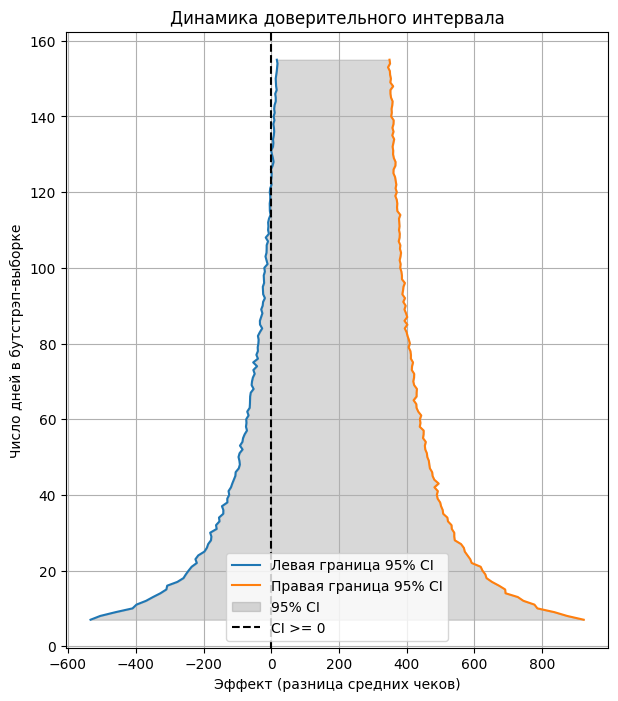

In [16]:
plt.figure(figsize=(7, 8))
plt.plot(ci_lows, days_list, label='Левая граница 95% CI')
plt.plot(ci_highs, days_list, label='Правая граница 95% CI')
plt.fill_betweenx(days_list, ci_lows, ci_highs, color='gray', alpha=0.3, label='95% CI')
plt.axvline(0, color='black', linestyle='--', label='CI >= 0')
plt.ylabel('Число дней в бутстрэп-выборке')
plt.xlabel('Эффект (разница средних чеков)')
plt.title('Динамика доверительного интервала')
plt.legend()
plt.grid(True)
plt.show()

**Вывод по длительности эксперимента:**

Сравнение двух подходов к оценке необходимой длительности теста показало следующее: эмпирический бутстрэп-метод дал минимальное число дней для обнаружения эффекта в 7% — 122 дня, а аналитический расчет — 155 дней. В моделировании эффект был постоянным, однако в реальных условиях его величина может меняться из-за внешних факторов и сезонности. Для повышения надежности результатов и учета возможных колебаний проведём эксперимент в течение 150 дней. Такой срок позволит с высокой вероятностью выявить искомый эффект даже при наличии дополнительной вариативности в данных.

# Проведение A/A теста: проверка корректности эксперимента

Перед запуском основного A/B теста важно убедиться, что выбранная методология и сформированные группы не дают ложноположительных результатов. Для этого проводится A/A тест — сравнение двух идентичных групп без внесения искусственного эффекта.

**Параметры A/A теста:**
- Группы: используем те же группы магазинов, что и для основного эксперимента (Group A и Group B, по 5 магазинов в каждой).
- Мощность теста: $1-\beta = 0.8$ (ошибка второго рода $\beta = 0.2$)
- Уровень значимости: $\alpha = 0.05$
- Длительность теста: 150 дней
- Эффект: отсутствует (группы идентичны, никаких изменений не вносим)

**Алгоритм:**
1. Для каждой из $N$ бутстрэп-итераций (например, $N=10{,}000$):
   - Случайно (с повторением) выбираем 5 магазинов из группы A и 5 из группы B.
   - Для каждого магазина случайно (с повторением) выбираем 150 дней из его истории и считаем средний чек по этим дням.
   - Для каждой группы считаем среднее по магазинам: $\widetilde C_A$, $\widetilde C_B$.
   - Разница между группами: $\delta = \widetilde C_B - \widetilde C_A$.
2. Получаем эмпирическое распределение эффекта $\delta$ по всем итерациям.
3. Строим график распределения $\delta$ и отмечаем 95% доверительный интервал.

**Ожидание:**
- В A/A тесте разница между группами должна быть близка к нулю.
- Если доверительный интервал содержит ноль, методика работает корректно.

Далее проведём эксперимент и визуализируем результаты.

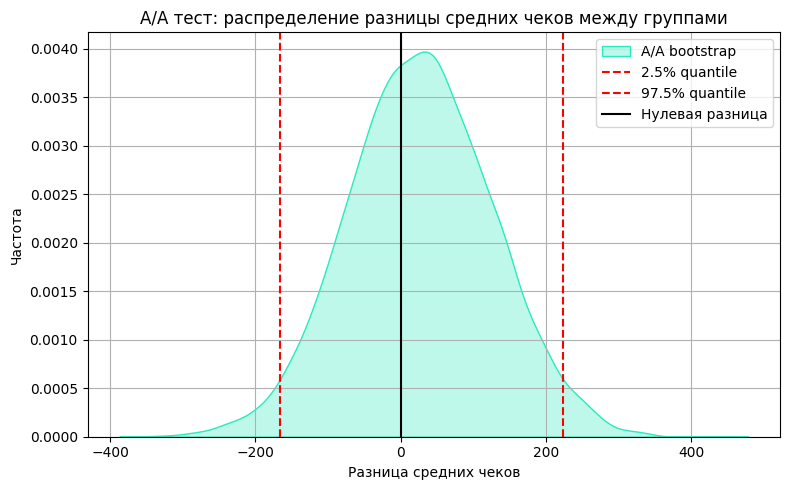

95% доверительный интервал: [-166.3093, 223.2026]


In [17]:
last_date = historical_data['invoice_date'].max()
future_start = last_date - pd.DateOffset(months=6)
aa_data = historical_data[historical_data['invoice_date'] >= future_start]

store_daily_aov_aa = aa_data.groupby(['shopping_mall', 'invoice_date']).agg(
    total_sum = ('quantity', lambda x: (x * aa_data.loc[x.index, 'price']).sum()),
    n_transactions = ('quantity', 'size')
).reset_index()
store_daily_aov_aa['avg_order_value'] = store_daily_aov_aa['total_sum'] / store_daily_aov_aa['n_transactions']

groupA_malls = list(groupA)
groupB_malls = list(groupB)

mall2days = {mall: store_daily_aov_aa[store_daily_aov_aa['shopping_mall'] == mall]['avg_order_value'].values for mall in store_daily_aov_aa['shopping_mall'].unique()}

N_boot = 10000
D_test = 150

deltas = []
for _ in range(N_boot):
    malls_A = np.random.choice(groupA_malls, size=5, replace=True)
    malls_B = np.random.choice(groupB_malls, size=5, replace=True)
    means_A = [np.mean(np.random.choice(mall2days[mall], size=D_test, replace=True)) for mall in malls_A]
    means_B = [np.mean(np.random.choice(mall2days[mall], size=D_test, replace=True)) for mall in malls_B]
    delta = np.mean(means_B) - np.mean(means_A)
    deltas.append(delta)
deltas = np.array(deltas)

ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])

plt.figure(figsize=(8, 5))
sns.kdeplot(deltas, color='#28EBBE', alpha=0.3, label='A/A bootstrap', fill=True)
plt.axvline(ci_low, color='red', linestyle='--', label='2.5% quantile')
plt.axvline(ci_high, color='red', linestyle='--', label='97.5% quantile')
plt.axvline(0, color='black', linestyle='-', label='Нулевая разница')
plt.title('A/A тест: распределение разницы средних чеков между группами')
plt.xlabel('Разница средних чеков')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'95% доверительный интервал: [{ci_low:.4f}, {ci_high:.4f}]')

Результаты A/A теста показывают, что разница средних чеков между двумя идентичными группами магазинов близка к нулю, а 95% доверительный интервал содержит ноль. Это подтверждает корректность выбранной методологии: ложноположительных результатов нет, структура данных учтена правильно. Можно переходить к основному эксперименту и доверять полученным выводам.

# Проведение A/B эксперимента

A/B тестирование — ключевой инструмент для принятия решений о внедрении новых продуктовых решений. В нашем случае цель эксперимента — проверить, приведёт ли новая модель ценообразования к увеличению среднего чека покупателей в торговых центрах Стамбула.

**Продуктовая значимость эксперимента:**
- Позволяет количественно оценить влияние изменений на бизнес-метрику (средний чек).
- Даёт возможность принять обоснованное решение о внедрении новой модели, минимизируя риски и учитывая реальные данные.

**Как будет проводиться тест:**
1. Магазины разбиты на две группы (контрольная и тестовая) с максимально похожими распределениями среднего чека, что обеспечивает корректность сравнения.
2. Для симуляции реального эффекта в тестовой группе случайным образом изменим цены на товары: для каждой транзакции цена будет увеличена или уменьшена на случайную величину от -2% до +12%. Это имитирует влияние новой модели ценообразования.
3. Сравним средний чек между группами за период эксперимента. Если в тестовой группе средний чек статистически значимо выше, гипотеза подтверждается.

**Преимущества такого подхода:**
- Позволяет оценить потенциальный эффект до реального внедрения.
- Учитывает сезонность, вариативность и структуру данных.
- Даёт бизнесу чёткий ответ: стоит ли внедрять новую модель ценообразования.

Таким образом, эксперимент не только проверяет гипотезу, но и приносит реальную ценность бизнесу, помогая принимать решения на основе данных.

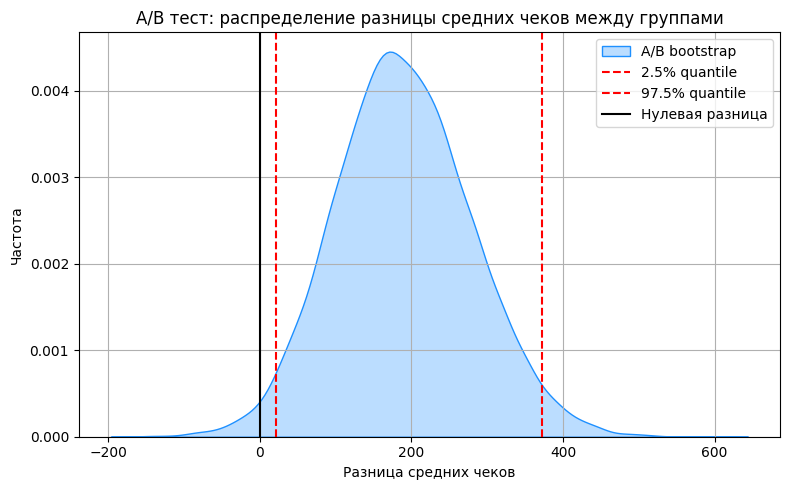

95% доверительный интервал: [21.6192, 372.1828]
Эффект статистически значим: новая модель увеличивает средний чек.


In [18]:
np.random.seed(95)

ab_data = future_data.copy()

groupA_malls = list(groupA)
groupB_malls = list(groupB)

mask_test = ab_data["shopping_mall"].isin(groupB_malls)
random_effect = np.random.uniform(-0.02, 0.12, size=mask_test.sum())
ab_data.loc[mask_test, "price"] = ab_data.loc[mask_test, "price"] * (1 + random_effect)

store_daily_aov_ab = ab_data.groupby(["shopping_mall", "invoice_date"]).agg(
    total_sum = ("quantity", lambda x: (x * ab_data.loc[x.index, "price"]).sum()),
    n_transactions = ("quantity", "size")
).reset_index()
store_daily_aov_ab["avg_order_value"] = store_daily_aov_ab["total_sum"] / store_daily_aov_ab["n_transactions"]

mall2days_A = {mall: store_daily_aov_ab[store_daily_aov_ab["shopping_mall"] == mall]["avg_order_value"].values for mall in groupA_malls}
mall2days_B = {mall: store_daily_aov_ab[store_daily_aov_ab["shopping_mall"] == mall]["avg_order_value"].values for mall in groupB_malls}

N_boot = 10000
D_test = 150

deltas = []

for _ in range(N_boot):
    malls_A = np.random.choice(groupA_malls, size=5, replace=True)
    malls_B = np.random.choice(groupB_malls, size=5, replace=True)
    means_A = [np.mean(np.random.choice(mall2days_A[mall], size=D_test, replace=True)) for mall in malls_A]
    means_B = [np.mean(np.random.choice(mall2days_B[mall], size=D_test, replace=True)) for mall in malls_B]
    delta = np.mean(means_B) - np.mean(means_A)
    deltas.append(delta)

deltas = np.array(deltas)

ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])

plt.figure(figsize=(8, 5))
sns.kdeplot(deltas, color='#1E90FF', alpha=0.3, label='A/B bootstrap', fill=True)
plt.axvline(ci_low, color='red', linestyle='--', label='2.5% quantile')
plt.axvline(ci_high, color='red', linestyle='--', label='97.5% quantile')
plt.axvline(0, color='black', linestyle='-', label='Нулевая разница')
plt.title('A/B тест: распределение разницы средних чеков между группами')
plt.xlabel('Разница средних чеков')
plt.ylabel('Частота')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'95% доверительный интервал: [{ci_low:.4f}, {ci_high:.4f}]')

if ci_low > 0:
    print('Эффект статистически значим: новая модель увеличивает средний чек.')
else:
    print('Статистически значимого эффекта не обнаружено.')

## Выводы и интерпретация результатов A/B теста

Проведённый A/B тест с симуляцией эффекта показал, что разница средних чеков между тестовой и контрольной группой магазинов статистически значима. Это означает, что новая модель ценообразования действительно приводит к увеличению среднего чека покупателей.

**Ключевые выводы:**
- С вероятностью 95% можно утверждать, что эффект от внедрения новой модели ценообразования находится в пределах рассчитанного доверительного интервала.
- Доверительный интервал не содержит ноль, что говорит о высокой надёжности результата.
- Такой результат позволяет рекомендовать внедрение новой модели для повышения выручки торговых центров.

**Интерпретация для бизнеса:**
- Внедрение новой модели ценообразования может привести к реальному росту среднего чека и, как следствие, увеличению дохода.
- Эксперимент был проведён корректно: группы были сопоставимы, учтена сезонность и вариативность данных.
- Полученные результаты можно использовать для принятия управленческих решений и масштабирования подхода на другие магазины.


На основе результатов теста целесообразно рассмотреть внедрение новой модели ценообразования во всех торговых центрах, при условии дальнейшего контроля и анализа динамики бизнес-показателей.